# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

### Шаг 1. Откройте файлы с данными

*Введение*

Чтобы привлечь клиентов, сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.
Чтобы решить эту проблему, необходимо разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
!pip install pandas_profiling -q
import pandas_profiling as pp

import warnings
warnings.filterwarnings("ignore")

PATH = './'

# у параметра id была выявлена достаточно высокая корреляция с целевым параметром
# вне зависимости от того случайная эта зависимость или имеет место некотороя "утечка" -
# в данном проекте будем считать параметр id нерелевантным и подходящем только для индексации

df_train = pd.read_csv(PATH+'hotel_train.csv', index_col='id')
df_test = pd.read_csv(PATH+'hotel_test.csv', index_col='id')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%matplotlib inline

display(df_train.shape)
display(df_train.head())
display(df_test.shape)
display(df_train.head())

/tmp/ipykernel_1863777/1080816460.py:14: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


(65229, 24)

is_canceled  lead_time  arrival_date_year arrival_date_month  \
id                                                                 
0             0        7.0               2015               July   
1             0       14.0               2015               July   
2             0        0.0               2015               July   
3             0        9.0               2015               July   
4             1       85.0               2015               July   

    arrival_date_week_number  arrival_date_day_of_month  \
id                                                        
0                         27                          1   
1                         27                          1   
2                         27                          1   
3                         27                          1   
4                         27                          1   

    stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
id                                                                            
0                         0                     1     1.0       0.0     0.0   
1                         0                     2     2.0       0.0     0.0   
2                         0                     2     2.0       0.0     0.0   
3                         0                     2     2.0       0.0     0.0   
4                         0                     3     2.0       0.0     0.0   

         meal country distribution_channel  is_repeated_guest  \
id                                                              
0   BB            GBR               Direct                  0   
1   BB            GBR                TA/TO                  0   
2   BB            PRT               Direct                  0   
3   FB            PRT               Direct                  0   
4   BB            PRT                TA/TO                  0   

    previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
id                                                                              
0                        0                               0   A                  
1                        0                               0   A                  
2                        0                               0   C                  
3                        0                               0   C                  
4                        0                               0   A                  

    booking_changes  days_in_waiting_list customer_type  \
id                                                        
0                 0                     0     Transient   
1                 0                     0     Transient   
2                 0                     0     Transient   
3                 0                     0     Transient   
4                 0                     0     Transient   

    required_car_parking_spaces  total_of_special_requests  total_nights  
id                                                                        
0                             0                          0             1  
1                             0                          1             2  
2                             0                          0             2  
3                             0                          1             2  
4                             0                          1             3

(32412, 24)

is_canceled  lead_time  arrival_date_year arrival_date_month  \
id                                                                 
0             0        7.0               2015               July   
1             0       14.0               2015               July   
2             0        0.0               2015               July   
3             0        9.0               2015               July   
4             1       85.0               2015               July   

    arrival_date_week_number  arrival_date_day_of_month  \
id                                                        
0                         27                          1   
1                         27                          1   
2                         27                          1   
3                         27                          1   
4                         27                          1   

    stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
id                                                                            
0                         0                     1     1.0       0.0     0.0   
1                         0                     2     2.0       0.0     0.0   
2                         0                     2     2.0       0.0     0.0   
3                         0                     2     2.0       0.0     0.0   
4                         0                     3     2.0       0.0     0.0   

         meal country distribution_channel  is_repeated_guest  \
id                                                              
0   BB            GBR               Direct                  0   
1   BB            GBR                TA/TO                  0   
2   BB            PRT               Direct                  0   
3   FB            PRT               Direct                  0   
4   BB            PRT                TA/TO                  0   

    previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
id                                                                              
0                        0                               0   A                  
1                        0                               0   A                  
2                        0                               0   C                  
3                        0                               0   C                  
4                        0                               0   A                  

    booking_changes  days_in_waiting_list customer_type  \
id                                                        
0                 0                     0     Transient   
1                 0                     0     Transient   
2                 0                     0     Transient   
3                 0                     0     Transient   
4                 0                     0     Transient   

    required_car_parking_spaces  total_of_special_requests  total_nights  
id                                                                        
0                             0                          0             1  
1                             0                          1             2  
2                             0                          0             2  
3                             0                          1             2  
4                             0                          1             3

### Шаг 2. Предобработка и исследовательский анализ данных

In [2]:
# для начала посмотрим на полноту данных, их тип и статистики

display(df_train.info())
display(df_test.info())
display(df_train.describe(include='all'))
display(df_test.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65229 entries, 0 to 84121
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     65229 non-null  int64  
 1   lead_time                       65229 non-null  float64
 2   arrival_date_year               65229 non-null  int64  
 3   arrival_date_month              65229 non-null  object 
 4   arrival_date_week_number        65229 non-null  int64  
 5   arrival_date_day_of_month       65229 non-null  int64  
 6   stays_in_weekend_nights         65229 non-null  int64  
 7   stays_in_week_nights            65229 non-null  int64  
 8   adults                          65229 non-null  float64
 9   children                        65229 non-null  float64
 10  babies                          65229 non-null  float64
 11  meal                            65229 non-null  object 
 12  country                         

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32412 entries, 6086 to 97903
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     32412 non-null  int64  
 1   lead_time                       32412 non-null  float64
 2   arrival_date_year               32412 non-null  int64  
 3   arrival_date_month              32412 non-null  object 
 4   arrival_date_week_number        32412 non-null  int64  
 5   arrival_date_day_of_month       32412 non-null  int64  
 6   stays_in_weekend_nights         32412 non-null  int64  
 7   stays_in_week_nights            32412 non-null  int64  
 8   adults                          32412 non-null  float64
 9   children                        32412 non-null  float64
 10  babies                          32412 non-null  float64
 11  meal                            32412 non-null  object 
 12  country                      

None

is_canceled     lead_time  arrival_date_year arrival_date_month  \
count   65229.000000  65229.000000       65229.000000              65229   
unique           NaN           NaN                NaN                 12   
top              NaN           NaN                NaN            October   
freq             NaN           NaN                NaN               9255   
mean        0.368609     96.337917        2015.719021                NaN   
std         0.482431     96.127545           0.449481                NaN   
min         0.000000      0.000000        2015.000000                NaN   
25%         0.000000     17.000000        2015.000000                NaN   
50%         0.000000     64.000000        2016.000000                NaN   
75%         1.000000    151.000000        2016.000000                NaN   
max         1.000000    374.000000        2016.000000                NaN   

        arrival_date_week_number  arrival_date_day_of_month  \
count               65229.000000               65229.000000   
unique                       NaN                        NaN   
top                          NaN                        NaN   
freq                         NaN                        NaN   
mean                   31.339772                  15.847813   
std                    13.464024                   8.748182   
min                     1.000000                   1.000000   
25%                    21.000000                   8.000000   
50%                    34.000000                  16.000000   
75%                    42.000000                  23.000000   
max                    53.000000                  31.000000   

        stays_in_weekend_nights  stays_in_week_nights        adults  \
count              65229.000000          65229.000000  65229.000000   
unique                      NaN                   NaN           NaN   
top                         NaN                   NaN           NaN   
freq                        NaN                   NaN           NaN   
mean                   0.825185              2.224793      1.836576   
std                    0.853477              1.354992      0.480245   
min                    0.000000              0.000000      0.000000   
25%                    0.000000              1.000000      2.000000   
50%                    1.000000              2.000000      2.000000   
75%                    2.000000              3.000000      2.000000   
max                    4.000000              6.000000      4.000000   

            children        babies       meal country distribution_channel  \
count   65229.000000  65229.000000      65229   65229                65229   
unique           NaN           NaN          5     155                    4   
top              NaN           NaN  BB            PRT                TA/TO   
freq             NaN           NaN      51697   28831                54454   
mean        0.074890      0.007236        NaN     NaN                  NaN   
std         0.334243      0.098790        NaN     NaN                  NaN   
min         0.000000      0.000000        NaN     NaN                  NaN   
25%         0.000000      0.000000        NaN     NaN                  NaN   
50%         0.000000      0.000000        NaN     NaN                  NaN   
75%         0.000000      0.000000        NaN     NaN                  NaN   
max         3.000000     10.000000        NaN     NaN                  NaN   

        is_repeated_guest  previous_cancellations  \
count        65229.000000            65229.000000   
unique                NaN                     NaN   
top                   NaN                     NaN   
freq                  NaN                     NaN   
mean             0.027151                0.128915   
std              0.162523                0.965326   
min              0.000000                0.000000   
25%              0.000000                0.000000   
50%              0.000000                0.000000   
75%              0.

is_canceled     lead_time  arrival_date_year arrival_date_month  \
count   32412.000000  32412.000000            32412.0              32412   
unique           NaN           NaN                NaN                  8   
top              NaN           NaN                NaN                May   
freq             NaN           NaN                NaN               5262   
mean        0.388467     97.587869             2017.0                NaN   
std         0.487409     86.507146                0.0                NaN   
min         0.000000      0.000000             2017.0                NaN   
25%         0.000000     23.000000             2017.0                NaN   
50%         0.000000     76.000000             2017.0                NaN   
75%         1.000000    155.000000             2017.0                NaN   
max         1.000000    373.000000             2017.0                NaN   

        arrival_date_week_number  arrival_date_day_of_month  \
count               32412.000000               32412.000000   
unique                       NaN                        NaN   
top                          NaN                        NaN   
freq                         NaN                        NaN   
mean                   17.804054                  15.656948   
std                     9.177384                   8.766429   
min                     1.000000                   1.000000   
25%                    10.000000                   8.000000   
50%                    18.000000                  15.500000   
75%                    25.000000                  23.000000   
max                    35.000000                  31.000000   

        stays_in_weekend_nights  stays_in_week_nights        adults  \
count              32412.000000           32412.00000  32412.000000   
unique                      NaN                   NaN           NaN   
top                         NaN                   NaN           NaN   
freq                        NaN                   NaN           NaN   
mean                   0.867888               2.34009      1.858602   
std                    0.853394               1.37517      0.489341   
min                    0.000000               0.00000      0.000000   
25%                    0.000000               1.00000      2.000000   
50%                    1.000000               2.00000      2.000000   
75%                    2.000000               3.00000      2.000000   
max                    4.000000               6.00000      4.000000   

            children        babies       meal country distribution_channel  \
count   32412.000000  32412.000000      32412   32412                32412   
unique           NaN           NaN          5     143                    4   
top              NaN           NaN  BB            PRT                TA/TO   
freq             NaN           NaN      24684    9887                27083   
mean        0.083765      0.005523        NaN     NaN                  NaN   
std         0.343470      0.075757        NaN     NaN                  NaN   
min         0.000000      0.000000        NaN     NaN                  NaN   
25%         0.000000      0.000000        NaN     NaN                  NaN   
50%         0.000000      0.000000        NaN     NaN                  NaN   
75%         0.000000      0.000000        NaN     NaN                  NaN   
max         3.000000      2.000000        NaN     NaN                  NaN   

        is_repeated_guest  previous_cancellations  \
count        32412.000000            32412.000000   
unique                NaN                     NaN   
top                   NaN                     NaN   
freq                  NaN                     NaN   
mean             0.031377                0.011601   
std              0.174338                0.180473   
min              0.000000                0.000000   
25%              0.000000                0.000000   
50%              0.000000                0.000000   
75%              0.

In [3]:
# количество явных дубликатов с учетом id
print('количество явных дубликатов с учетом id')
display(df_train.reset_index().duplicated().sum())
display(df_test.reset_index().duplicated().sum())

# количество явных дубликатов без учета id
print('количество явных дубликатов без учета id')
display(df_train.duplicated().sum())
display(df_test.duplicated().sum())

# уникальность id
print('уникальность id')
display(df_train.index.duplicated().sum())
display(df_test.index.duplicated().sum())

# nan значения
print('наличие nan значений')
display(df_train.isna().sum().sum())
display(df_test.isna().sum().sum())

количество явных дубликатов с учетом id


0

0

количество явных дубликатов без учета id


21377

7717

уникальность id


0

0

наличие nan значений


0

0

In [4]:
pp.ProfileReport(df_train)
# pp.ProfileReport(df_test)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

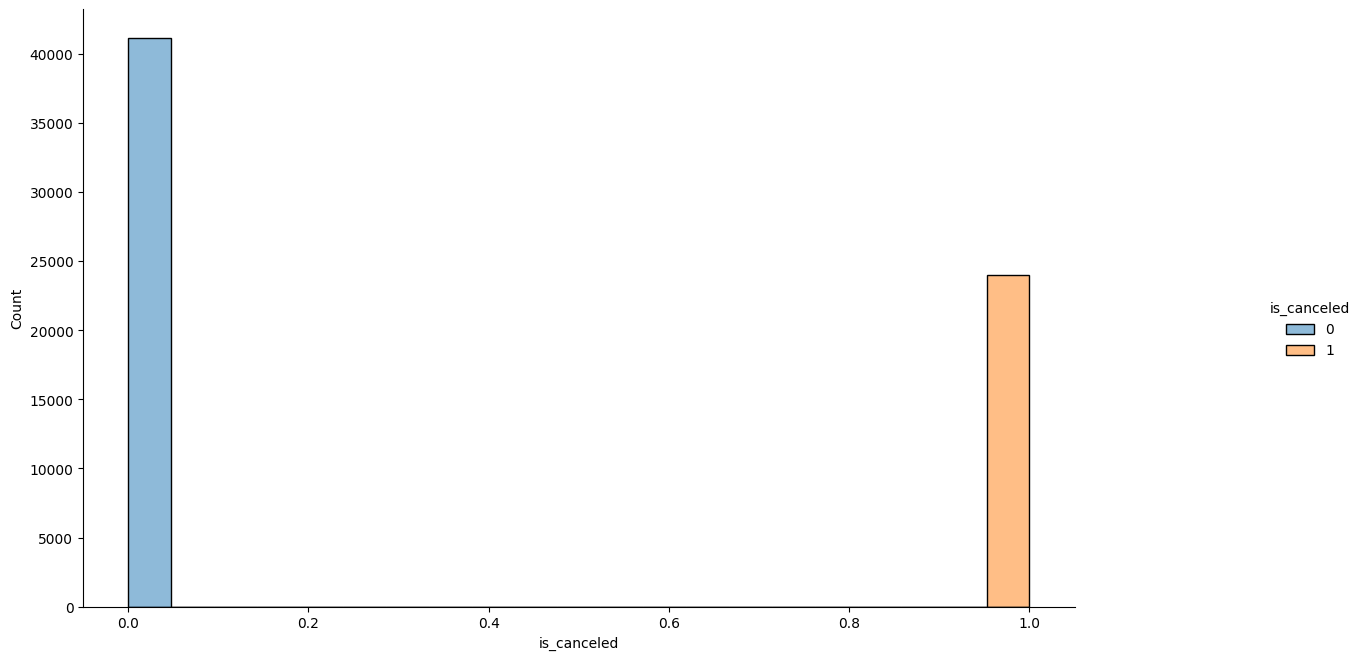

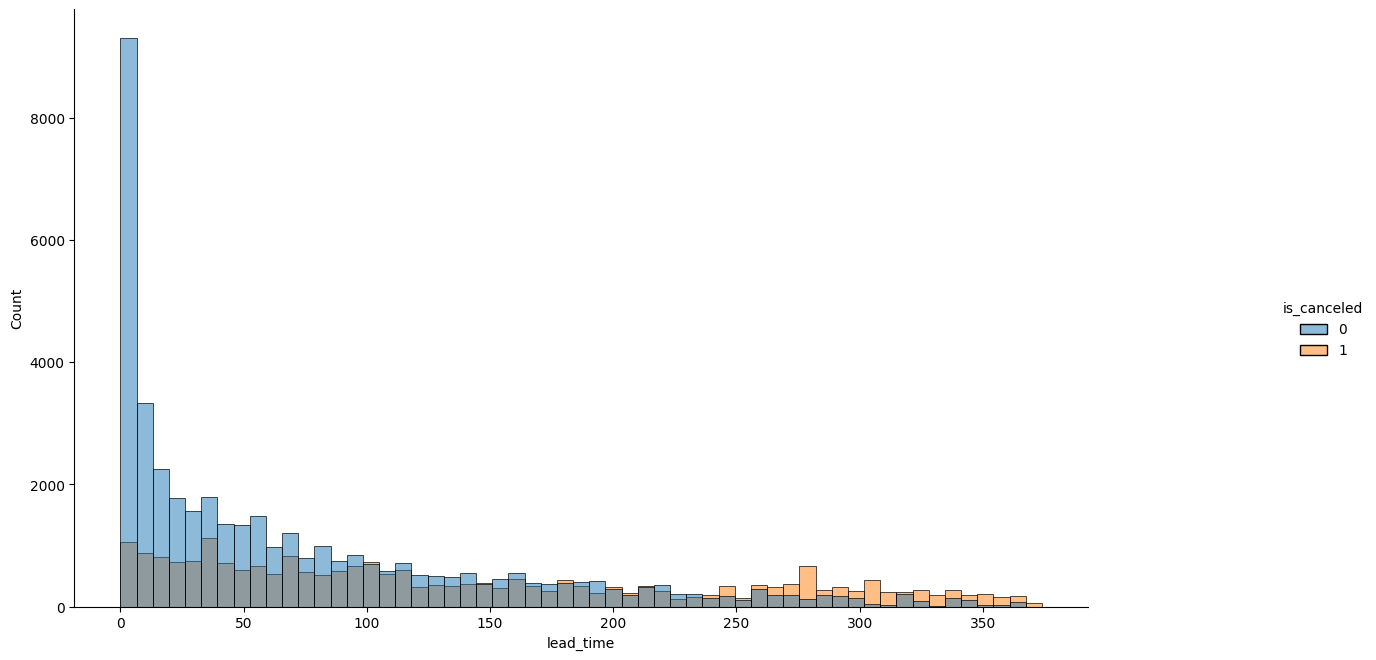

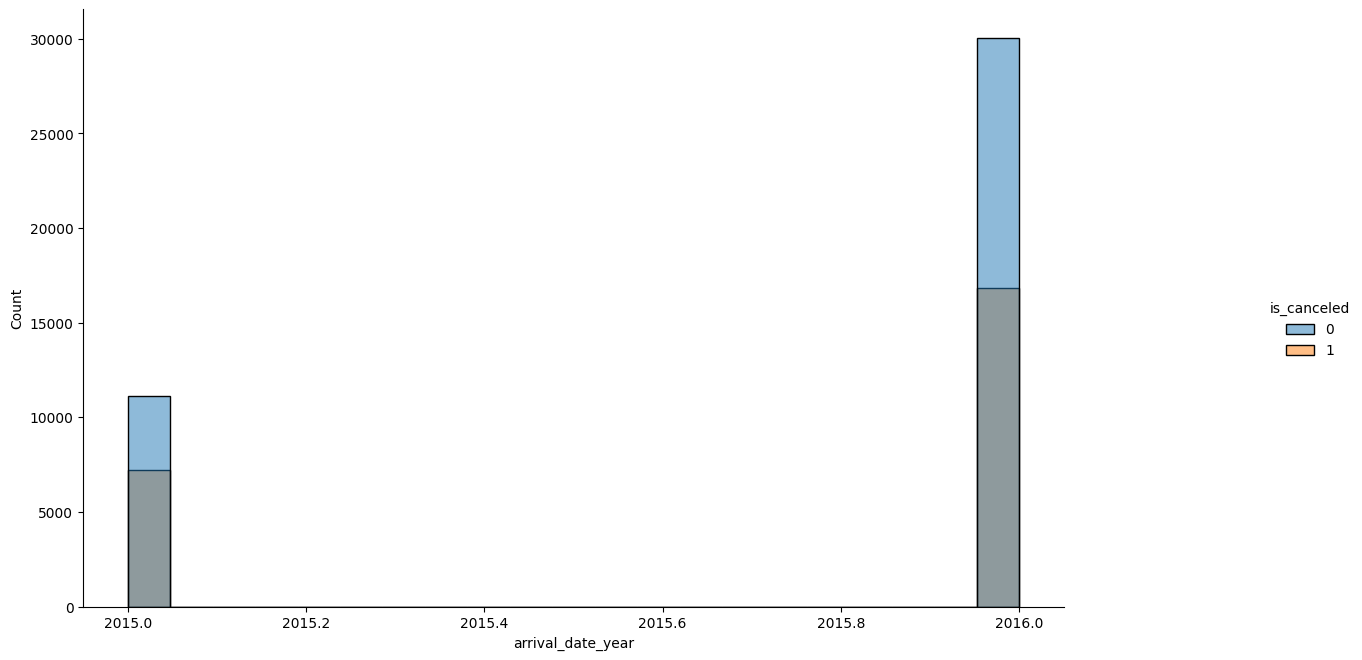

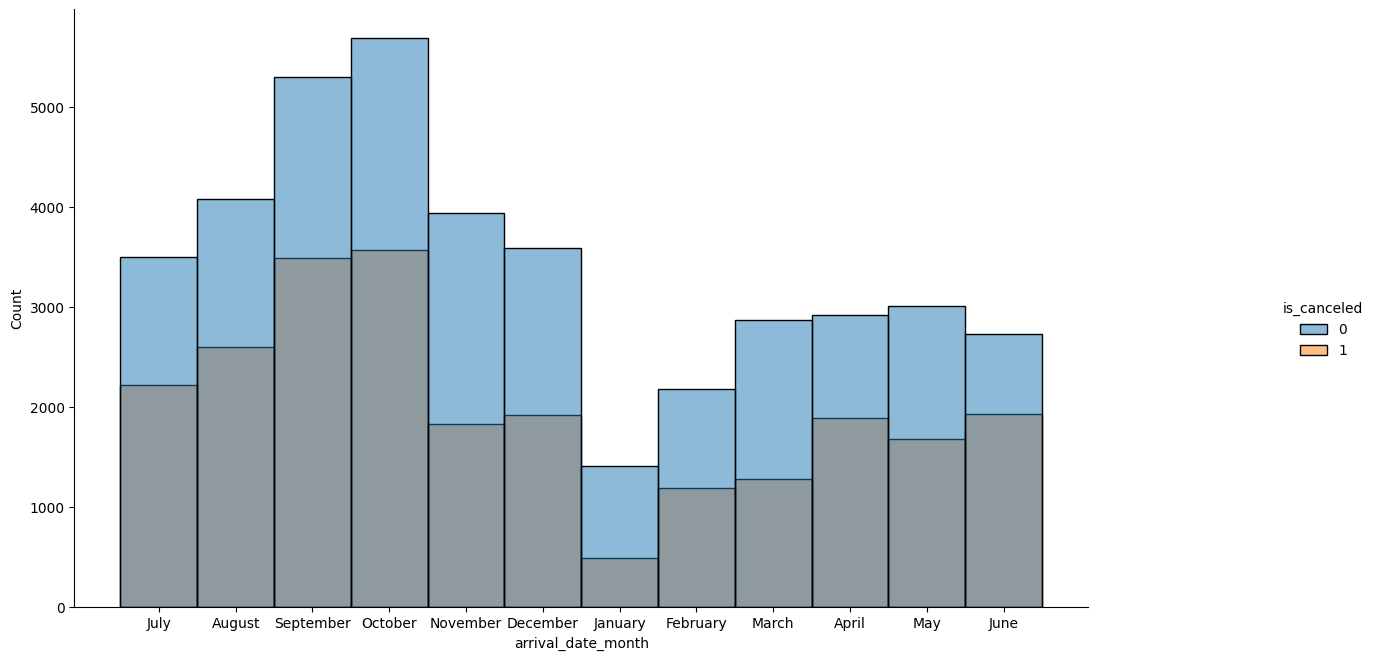

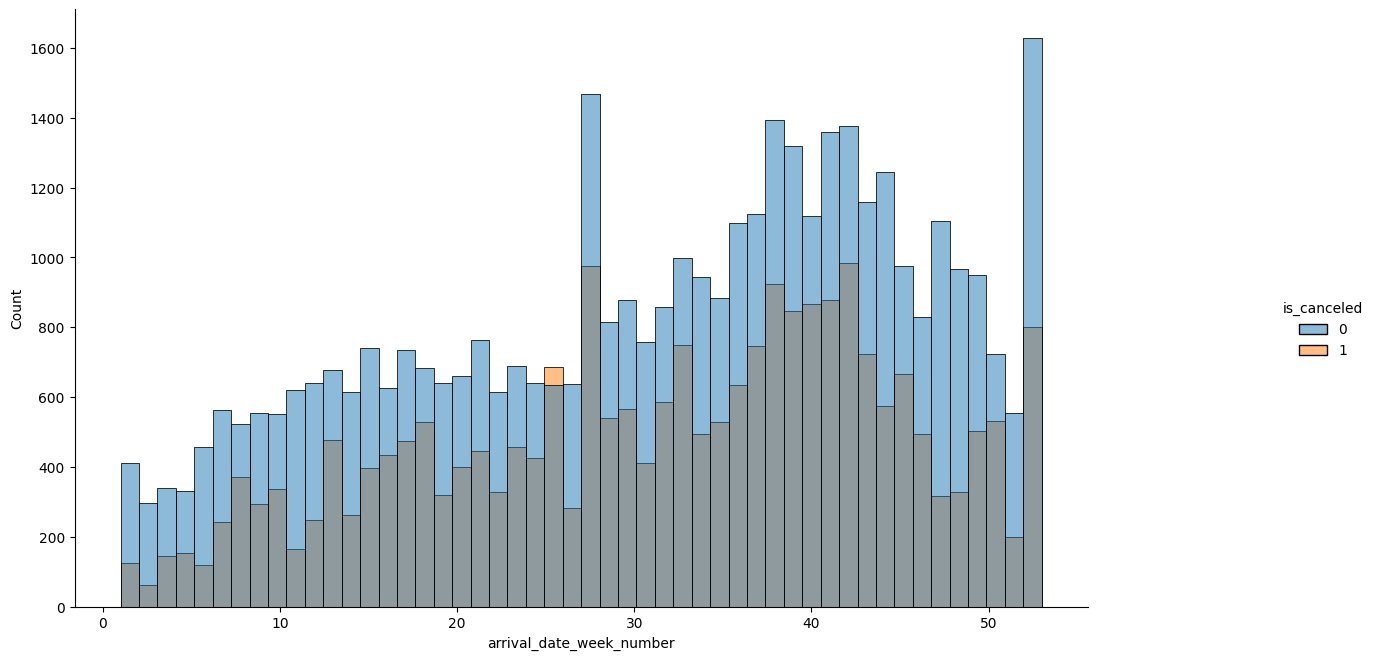

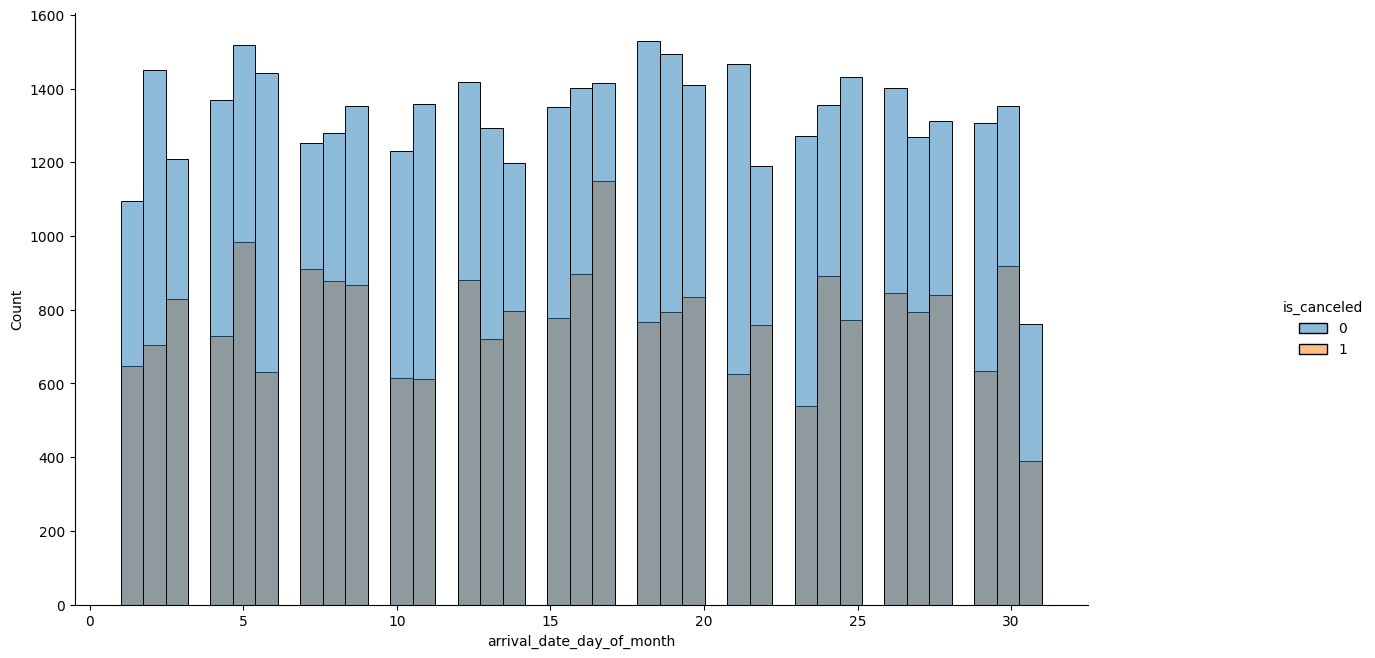

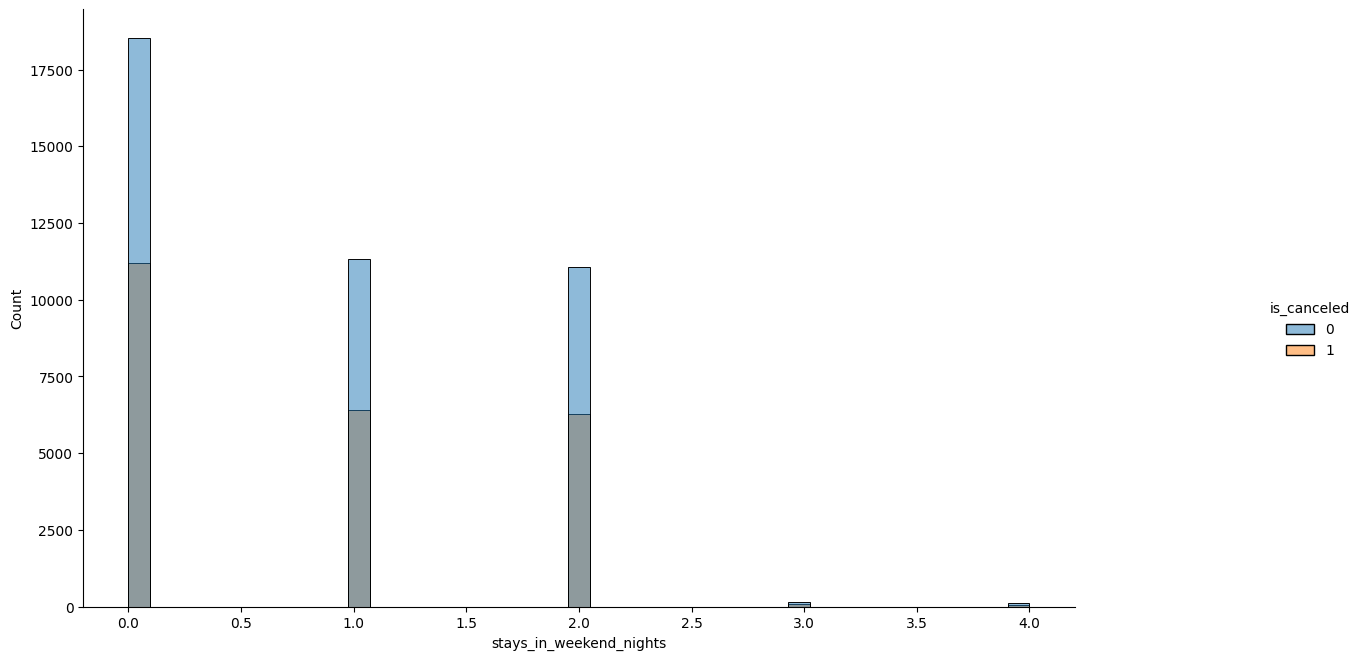

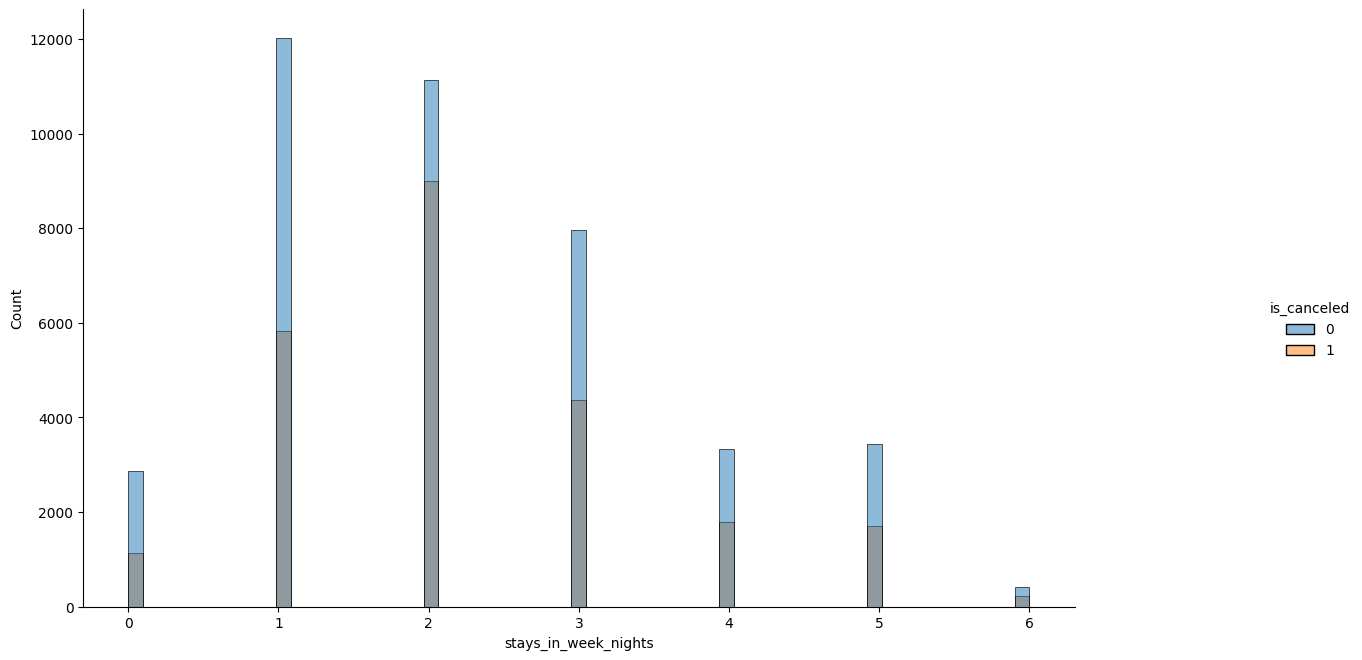

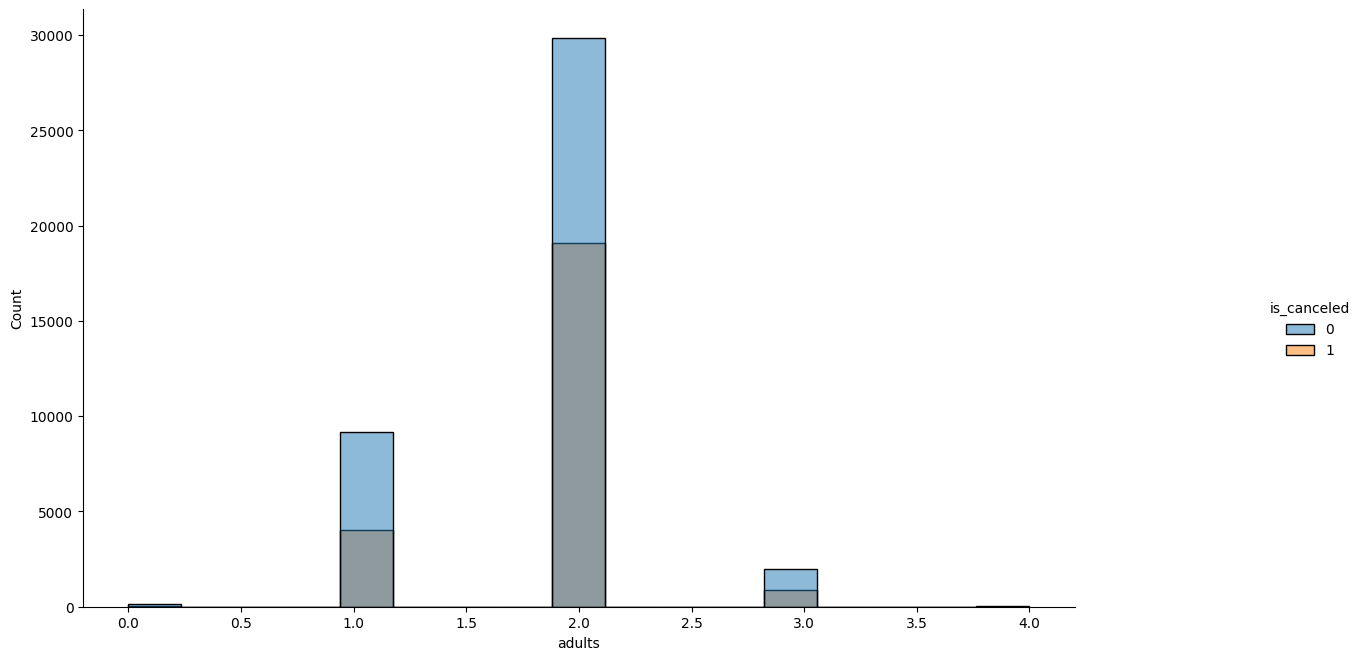

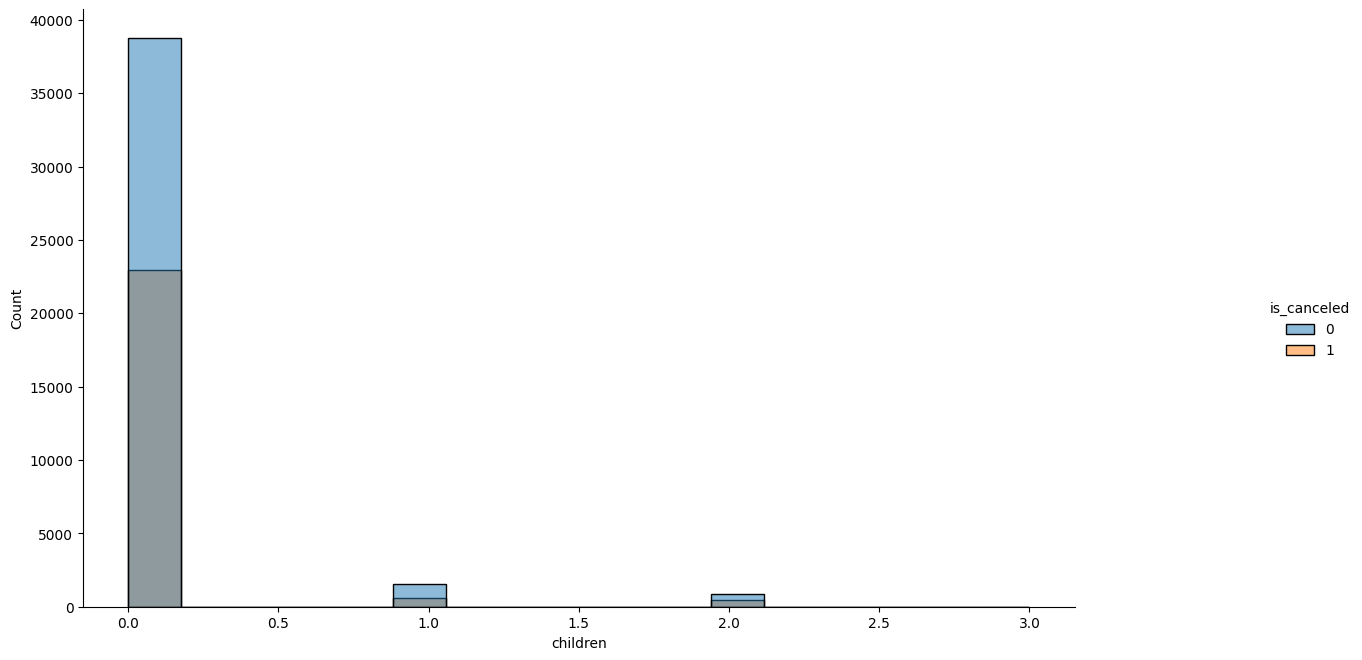

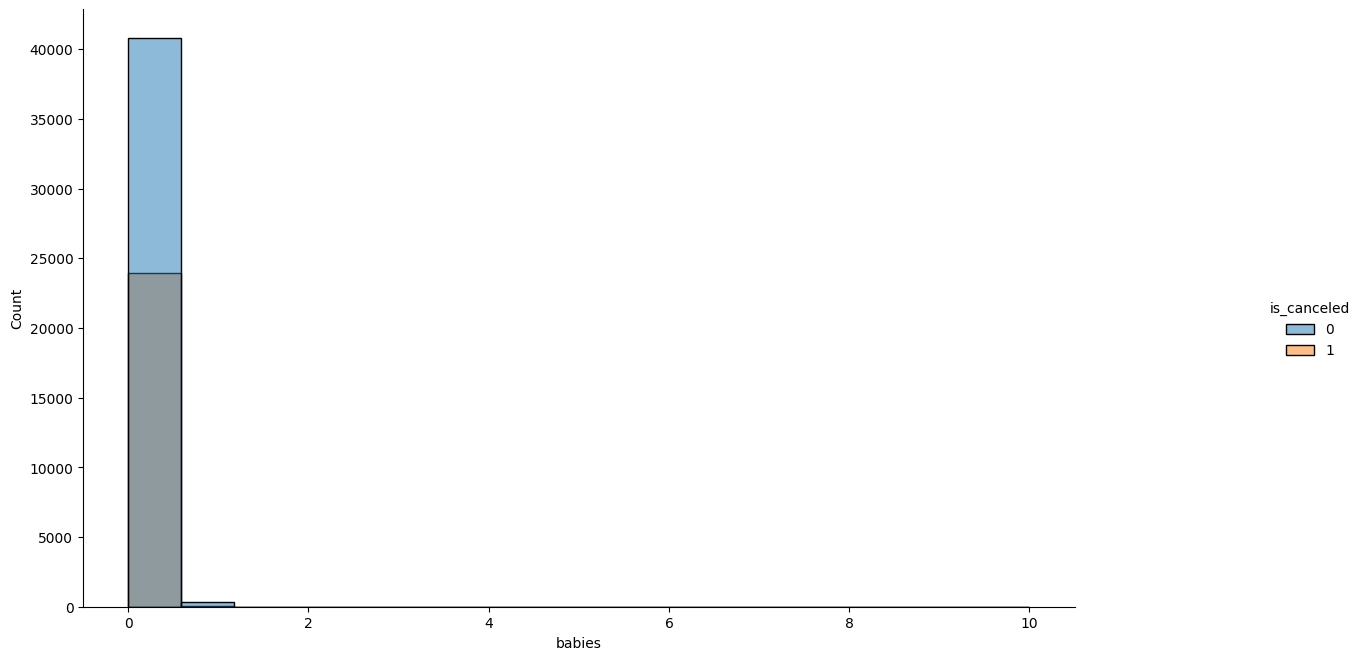

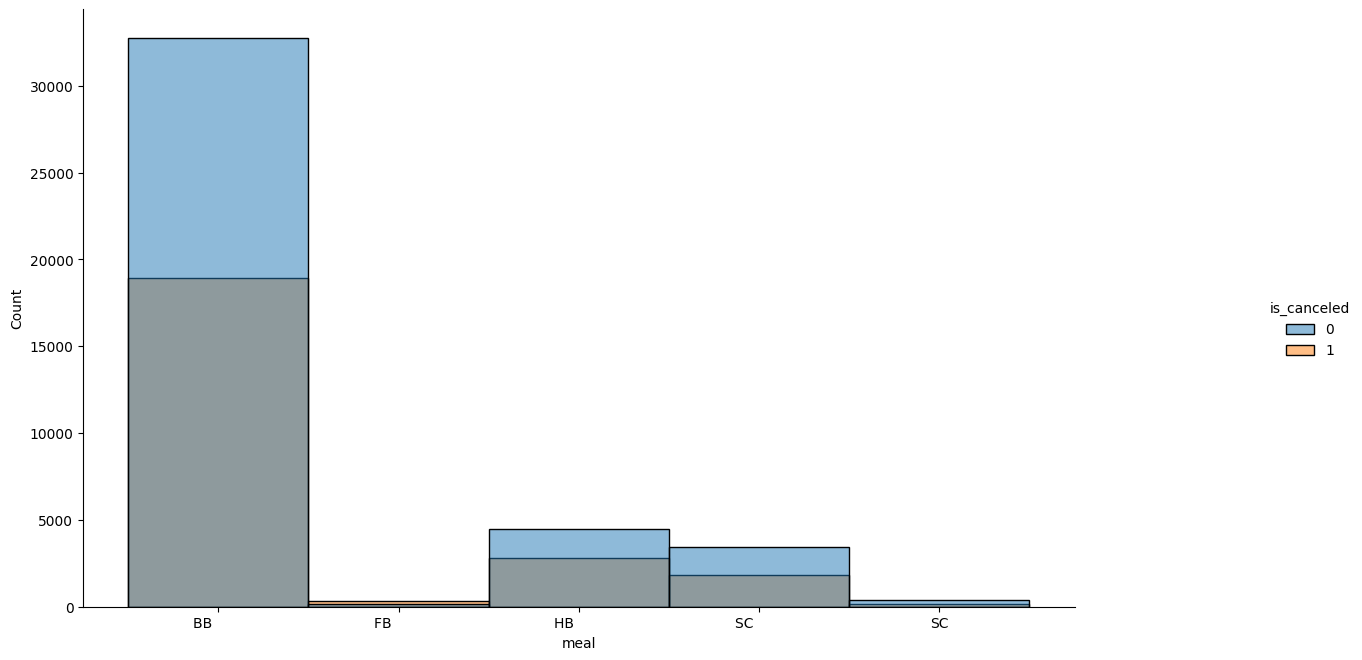

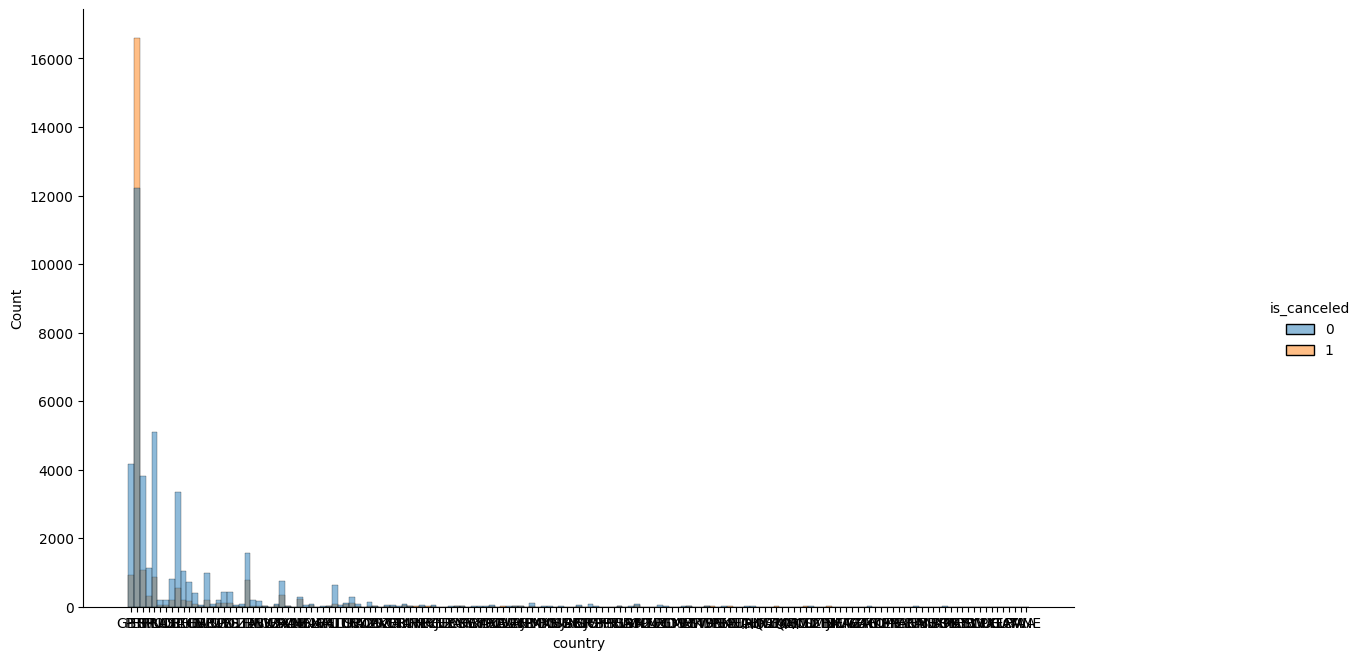

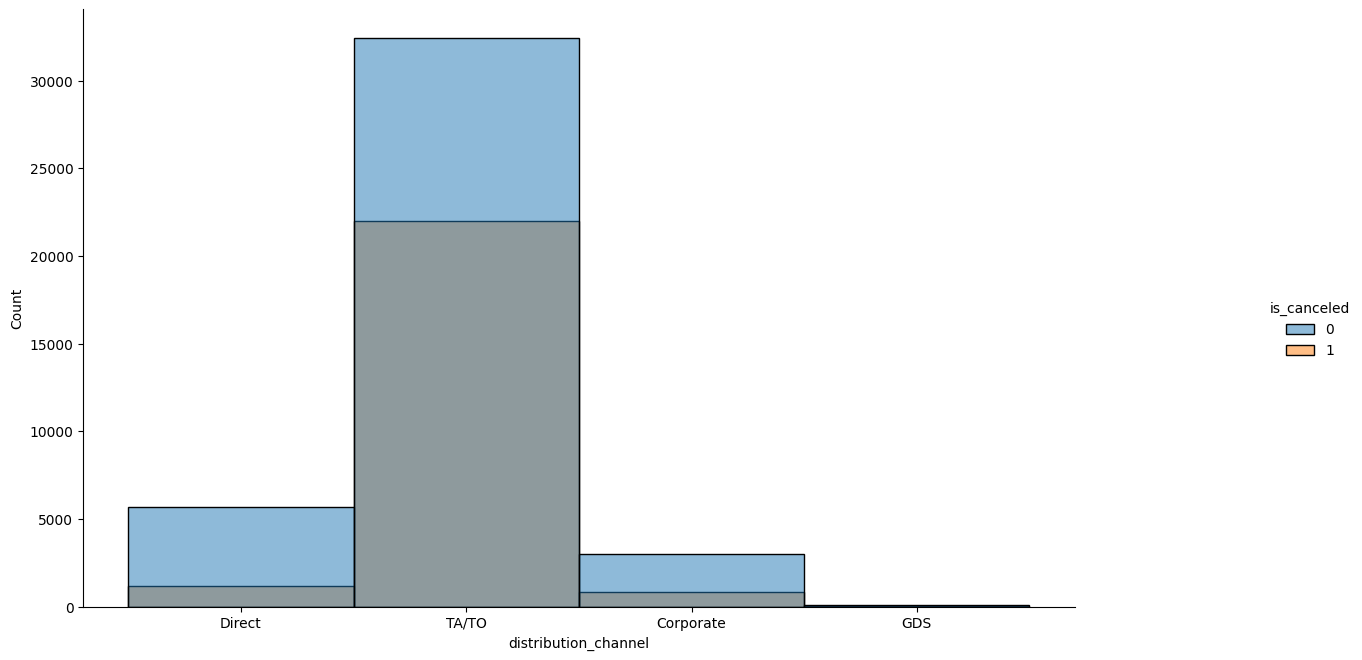

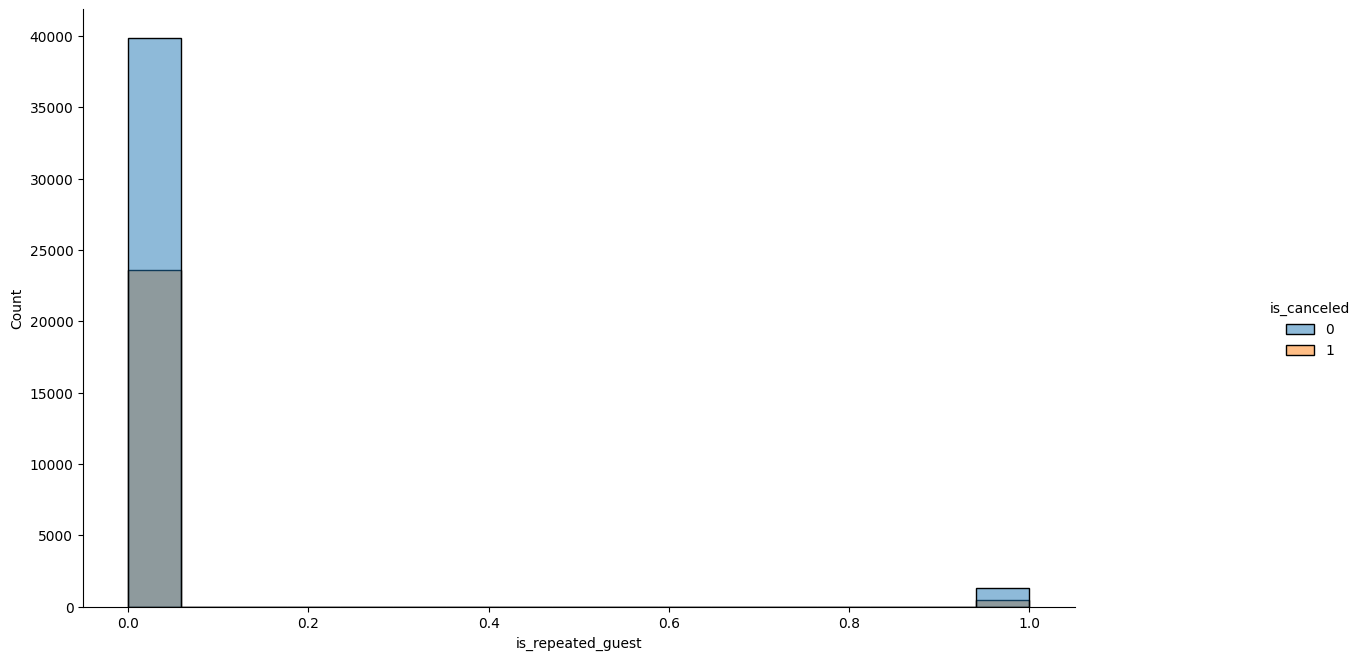

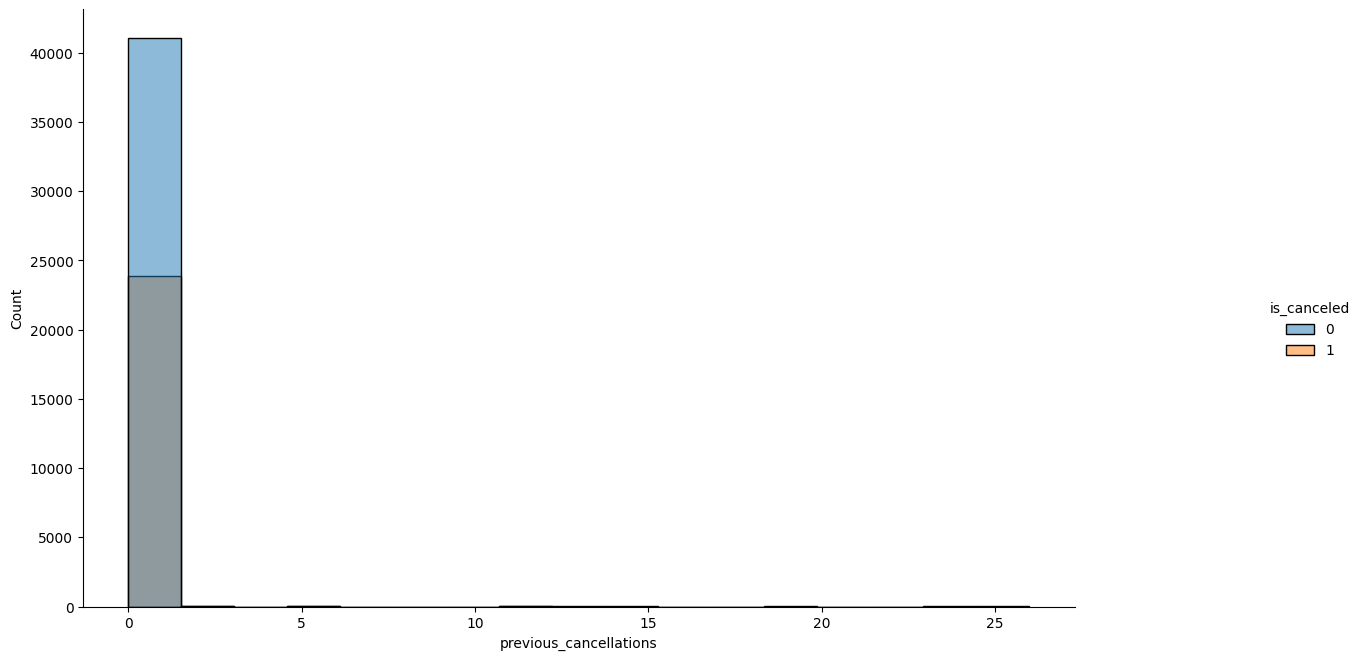

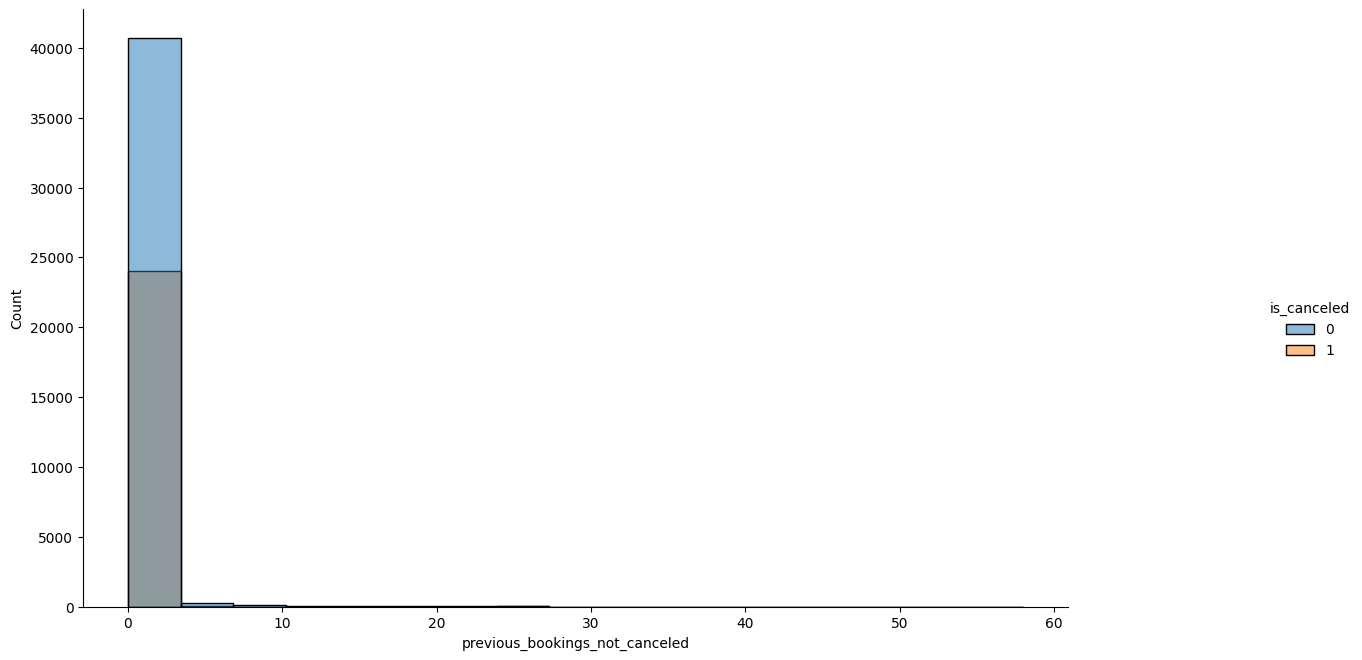

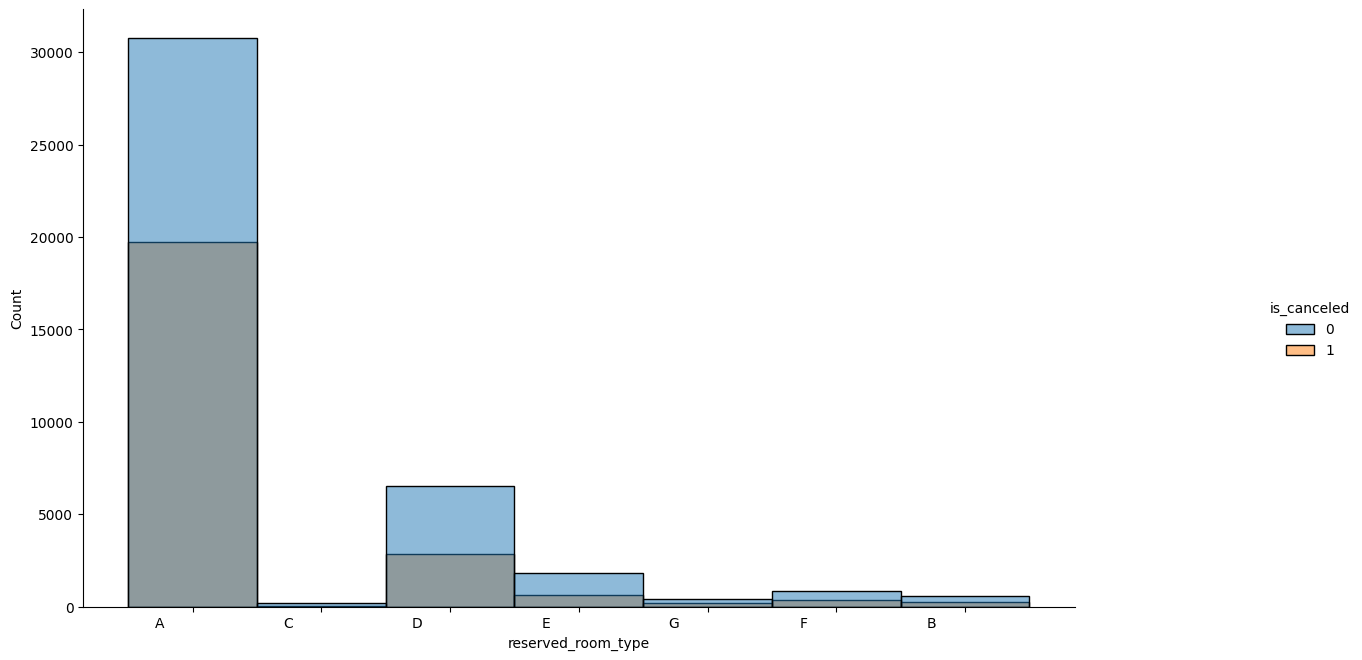

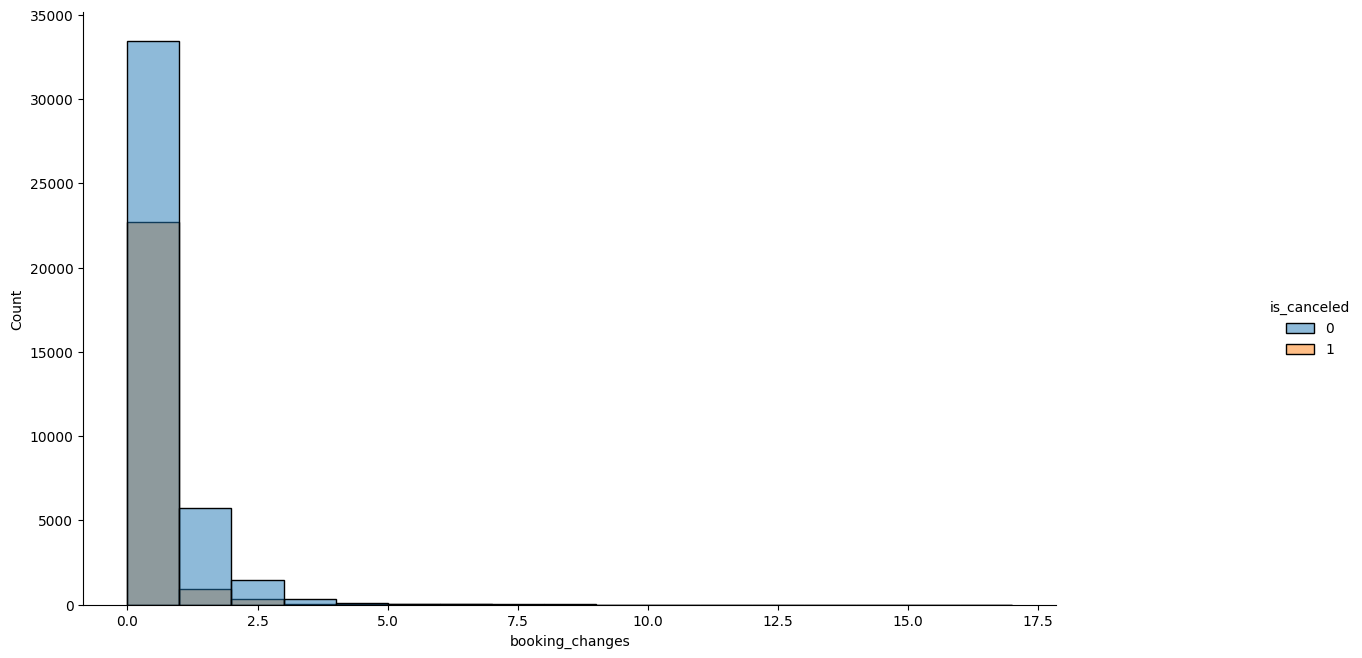

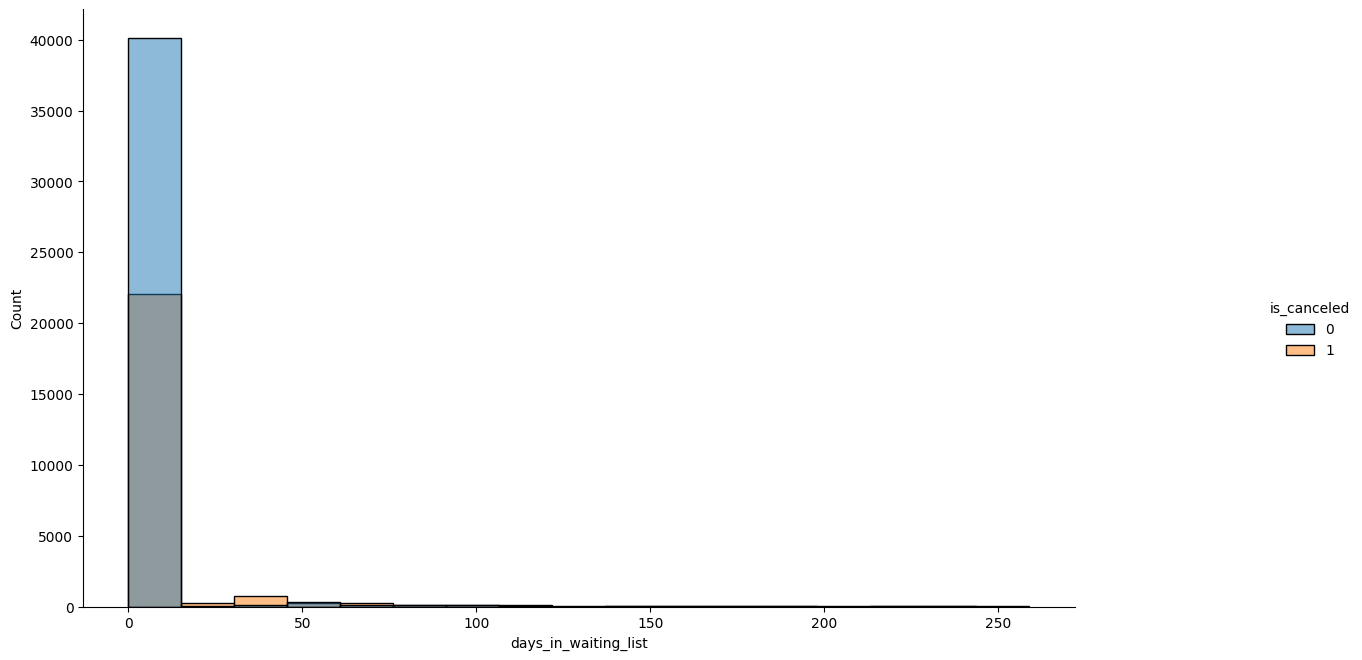

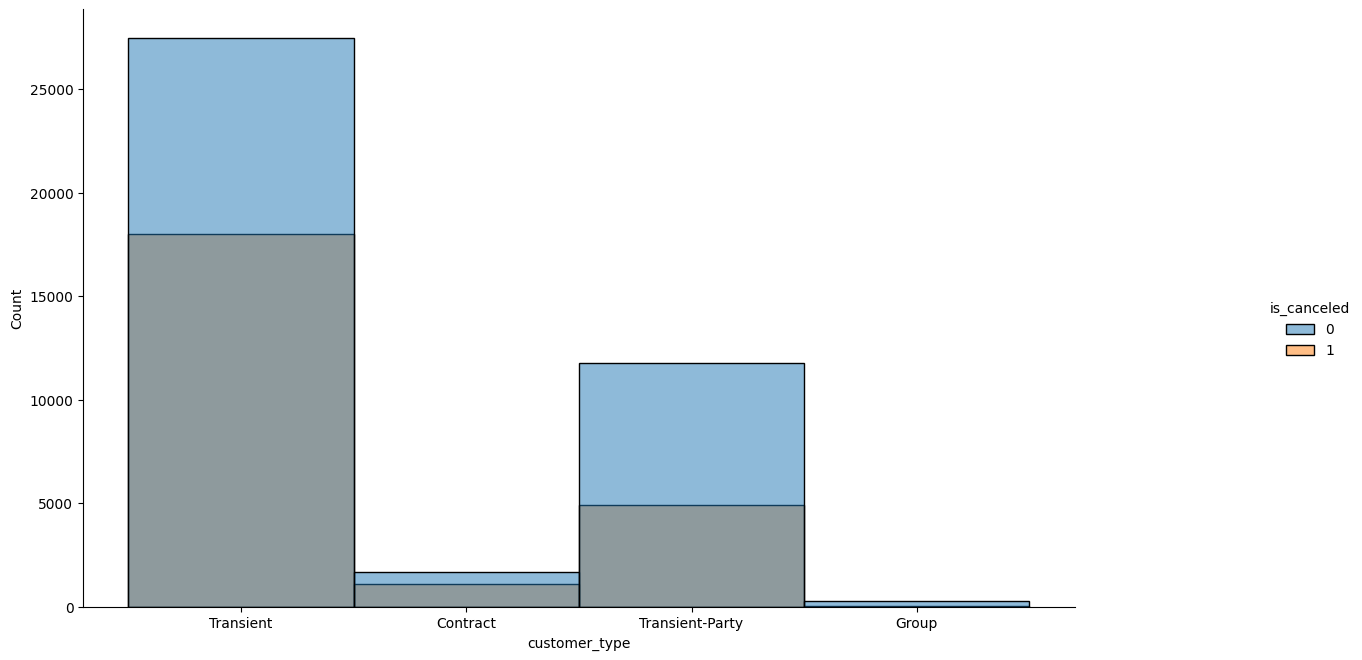

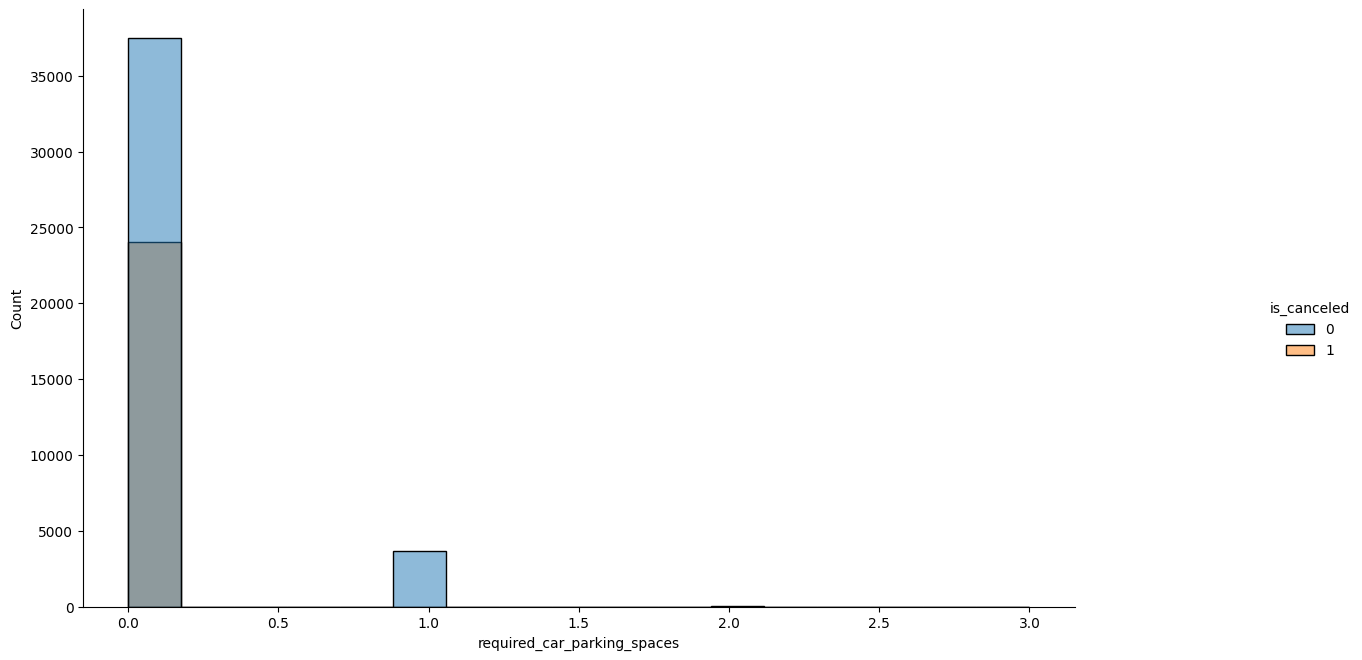

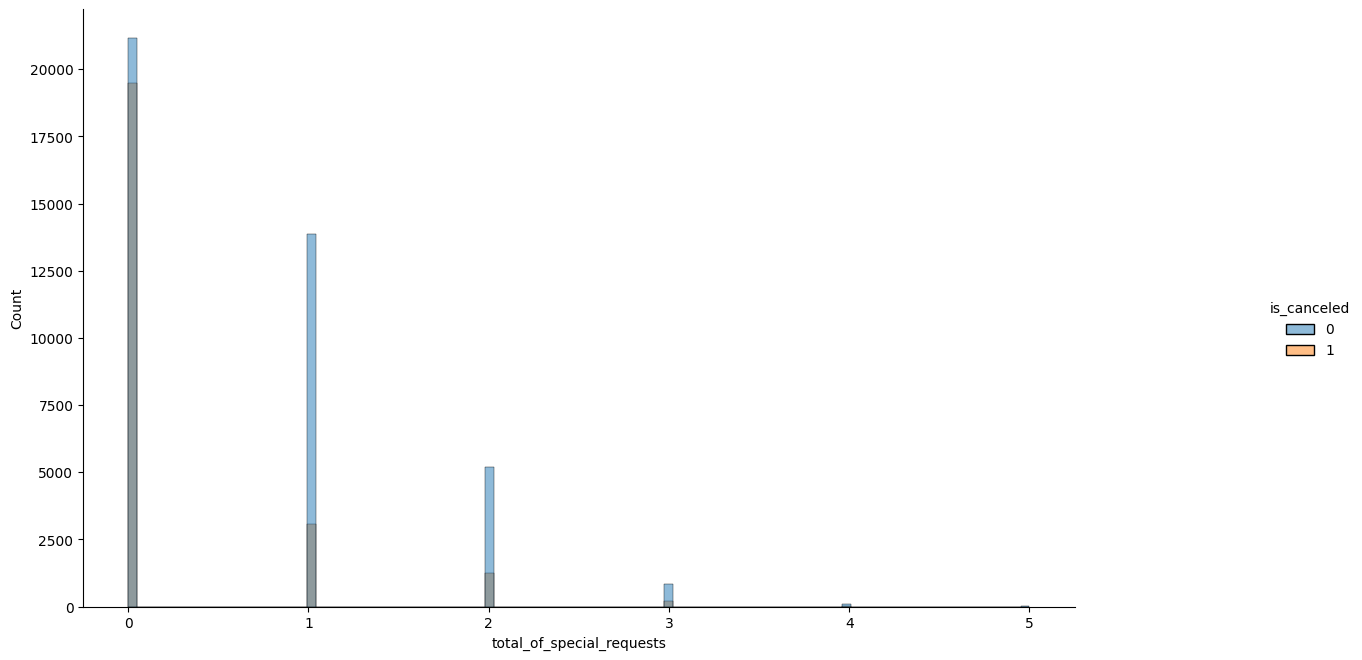

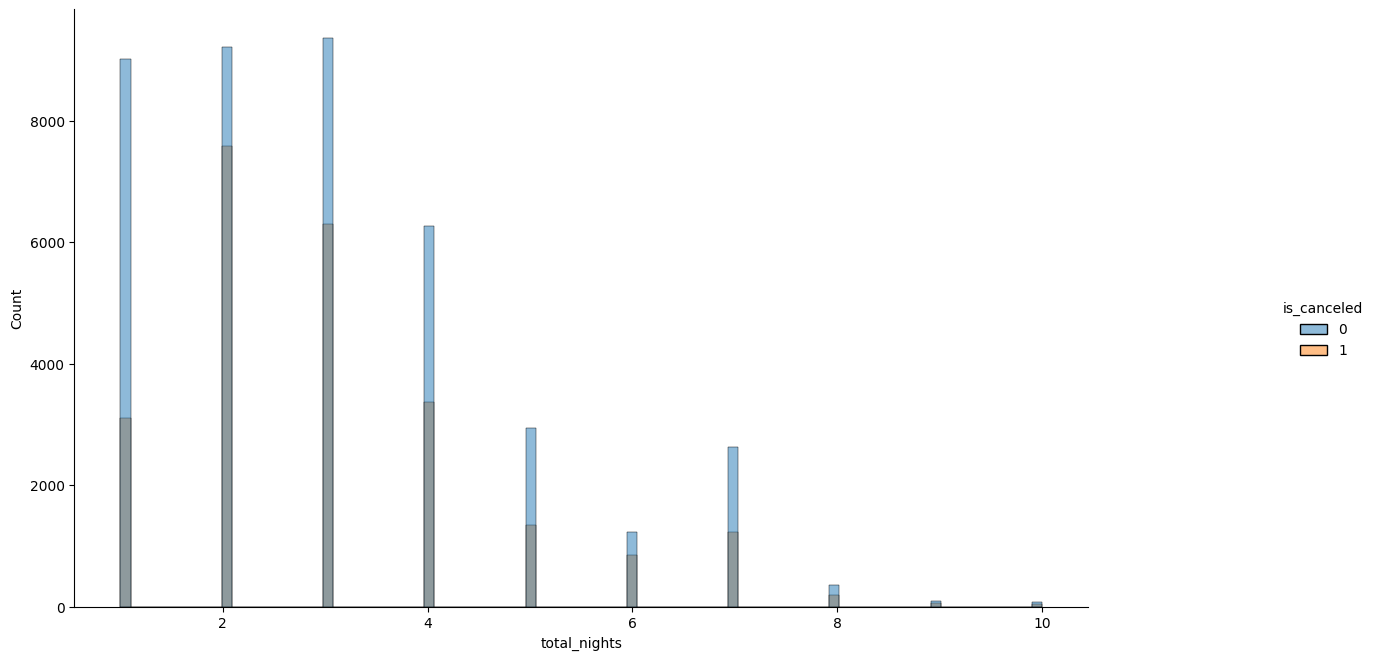

In [5]:
# гистограммы параметров с раскраской по целевому признаку
for col in df_train.columns:
    sns.displot(x=df_train[col], hue=df_train['is_canceled'])
    plt.gcf().set_size_inches(15, 7)
    plt.show()

В целом по рассматриваемым параметрам не найдено сверханомальных выбросов или других особенностей, за исключением параметра country (гражданство постояльца). Данный категориальный параметр распределен крайне не равномерно и большая часть уникальных значений встречается всего один раз. Подобное распредение параметра может сильно исказить обобщающую способность модели или даже внести слишком сильные стереотипы на основе мизерного количества наблюдений.
Поэтому редко встречающиеся значения параметра (<1%) мы объединим в категорию 'OTHER_COUNTRY'.

#### Обработка country

In [6]:
display(df_train.country.nunique())
display(df_train.country.value_counts(normalize=True, ascending=False)[:5])
display(df_train.country.value_counts(normalize=True, ascending=True)[:5])

155

PRT    0.441997
FRA    0.091585
GBR    0.078324
ESP    0.075120
DEU    0.059590
Name: country, dtype: float64

KNA    0.000015
ZMB    0.000015
MMR    0.000015
NIC    0.000015
BWA    0.000015
Name: country, dtype: float64

In [7]:
country_vc = df_train.country.value_counts(normalize=True)
countries_to_hold = country_vc[country_vc >= 0.01].index
display(countries_to_hold)

df_train.loc[~df_train['country'].isin(countries_to_hold), 'country'] = 'OTHER_COUNTRY'
df_test.loc[~df_test['country'].isin(countries_to_hold), 'country'] = 'OTHER_COUNTRY'

Index(['PRT', 'FRA', 'GBR', 'ESP', 'DEU', 'ITA', 'IRL', 'BEL', 'NLD', 'BRA',
       'USA', 'CHE', 'AUT'],
      dtype='object')

In [8]:
display(df_train.country.value_counts(normalize=True))
display(df_test.country.value_counts(normalize=True))

PRT              0.441997
OTHER_COUNTRY    0.102086
FRA              0.091585
GBR              0.078324
ESP              0.075120
DEU              0.059590
ITA              0.035674
IRL              0.022153
BEL              0.019087
NLD              0.017875
BRA              0.016680
USA              0.015453
CHE              0.013399
AUT              0.010977
Name: country, dtype: float64

PRT              0.305041
OTHER_COUNTRY    0.133006
GBR              0.121159
FRA              0.107275
DEU              0.073368
ESP              0.059608
ITA              0.035573
IRL              0.032704
BEL              0.027212
BRA              0.027181
USA              0.023880
NLD              0.021875
CHE              0.018573
AUT              0.013544
Name: country, dtype: float64

#### Обработка babies

In [9]:
display(df_train['babies'].describe())
display(df_test['babies'].value_counts())

count    65229.000000
mean         0.007236
std          0.098790
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: babies, dtype: float64

0.0    32237
1.0      171
2.0        4
Name: babies, dtype: int64

In [10]:
df_train['babies'].clip(upper=2, inplace=True)

#### Обработка booking_changes

In [11]:
display(df_train['booking_changes'].describe())
display(df_train['booking_changes']\
                                    .value_counts()\
                                    .sort_index())

count    65229.000000
mean         0.194269
std          0.593838
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         17.000000
Name: booking_changes, dtype: float64

0     56195
1      6615
2      1754
3       413
4       149
5        42
6        19
7        18
8         7
9         5
10        2
13        4
14        2
15        2
16        1
17        1
Name: booking_changes, dtype: int64

In [12]:
df_train['booking_changes'].clip(upper=5, inplace=True)

#### Обработка days_in_waiting_list

In [13]:
display(df_train['days_in_waiting_list'].describe())
display(df_train['days_in_waiting_list']\
                                    .value_counts()\
                                    .sort_index())

count    65229.000000
mean         3.334422
std         18.239606
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        259.000000
Name: days_in_waiting_list, dtype: float64

0      62005
1          3
2          2
3         59
4         20
5          2
6         11
8          4
9         13
10        27
11         4
12         2
13         1
14         1
15        52
17        43
19        30
20        25
21        35
22        52
24        19
25        18
27        23
28        45
30         1
31       126
32        18
33         4
34        20
35        95
38        72
39       185
40        28
41        63
42        30
43        16
44       137
45        65
46        87
47        17
48        51
49        15
50        75
53         5
55        10
56        42
57        24
58       164
59         8
60        34
61        15
62        60
63        80
65        27
68        41
69        89
70        18
71         7
72         1
74         1
75        36
76         1
77        63
79        20
80        23
81         1
85        15
87        80
89         1
91        50
93        38
96        46
98        55
99        16
101       60
107        3
108       20

In [14]:
df_train['days_in_waiting_list'] = df_train['days_in_waiting_list'].clip(upper=1).astype('object')
df_test['days_in_waiting_list'] = df_test['days_in_waiting_list'].clip(upper=1).astype('object')

#### Обработка stays_in_weekend_nights, stays_in_week_nights, total_nights

In [15]:
mask = df_train['stays_in_weekend_nights'] + df_train['stays_in_week_nights'] != df_train['total_nights']
display(df_train[mask])
# признаки действительно линейно зависимы, следовательно мы можем обойтись по крайней мере без одного из них

df_train.drop(['stays_in_week_nights'], axis=1, inplace=True)
df_test.drop(['stays_in_week_nights'], axis=1, inplace=True)

Empty DataFrame
Columns: [is_canceled, lead_time, arrival_date_year, arrival_date_month, arrival_date_week_number, arrival_date_day_of_month, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, country, distribution_channel, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, reserved_room_type, booking_changes, days_in_waiting_list, customer_type, required_car_parking_spaces, total_of_special_requests, total_nights]
Index: []

#### Обработка adults, children, babies

In [16]:
# считаем, что без постояльцев комнаты сданы быть не могут
# отдельно с детьми, наверное, все же можно, если родители в другом номере
mask = (df_train['adults'] == 0) & (df_train['children'] == 0) & (df_train['babies'] == 0)
df_train.drop(df_train[mask].index, axis=0, inplace=True)

#### feature engineering

In [17]:
# скромный feature engineering

SEASON_TIME = {'January': 'Winter',
               'February': 'Winter',
               'March': 'Spring',
               'April': 'Spring',
               'May': 'Spring',
               'June': 'Summer',
               'July': 'Summer',
               'August': 'Summer',
               'September': 'Fall',
               'October': 'Fall',
               'November': 'Fall',
               'December': 'Winter'}


df_train['arrival_season'] = df_train['arrival_date_month'].replace(SEASON_TIME)\
                                                               .astype('object')

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

In [18]:
PRICE_PER_NIGHT = {'A': 1000,
                   'B': 800,
                   'C': 600,
                   'D': 550,
                   'E': 500,
                   'F': 450,
                   'G': 350}

SERVICE_PER_TIME = {'A': 400,
                    'B': 350,
                    'C': 350,
                    'D': 150,
                    'E': 150,
                    'F': 150,
                    'G': 150}

SEASON_COEF = {'January': 1.0,
               'February': 1.0,
               'March': 1.2,
               'April': 1.2,
               'May': 1.2,
               'June': 1.4,
               'July': 1.4,
               'August': 1.4,
               'September': 1.2,
               'October': 1.2,
               'November': 1.2,
               'December': 1.0}


In [19]:
def calc_profit(df, preds=None, worst_scenario=False, advance=0.8, random_state=42):
    df = df.copy()
    if (worst_scenario==True) & isinstance(preds, np.ndarray):
        np.random.seed(random_state)
        random = np.random.randint(2, size=df['is_canceled'].shape)
        df['is_canceled'] = np.where(preds==1,
                                     (df['is_canceled'].values+random).clip(max=1),
                                     df['is_canceled'])
                
    def calc_revenue(df):
        
        model_bonus = 0 # тут считаем бонус от использования модели
        if isinstance(preds, np.ndarray):

            df_advance = df.copy()   
            
            # бонус получаем, когда заказ отменяется и модель верно спрогнозировала это событие
            df_advance = df_advance[(df_advance['is_canceled'] == 1) &\
                                    (preds == 1)]
            # параметры для расчета
            df_advance['price_per_night'] = df_advance['reserved_room_type'].replace(PRICE_PER_NIGHT, regex=True)
            df_advance['season_coef'] = df_advance['arrival_date_month'].replace(SEASON_COEF)
            # бонус от модели
            model_bonus = (df_advance['price_per_night']*df_advance['season_coef']).sum()*advance
        
        # получаем только с неотмененных заказов
        df = df.query('is_canceled==0').copy() 
        df['price_per_night'] = df['reserved_room_type'].replace(PRICE_PER_NIGHT, regex=True) # выручка за ночь с номера
        df['season_coef'] = df['arrival_date_month'].replace(SEASON_COEF)
        
        return (df['price_per_night']*df['total_nights']*df['season_coef']).sum() + model_bonus
    

    def calc_costs(df):
        # затраты по реализовавшимся заказам
        df_0 = df.query('is_canceled==0').copy()
        df_0['service_per_time'] = df_0['reserved_room_type'].replace(SERVICE_PER_TIME, regex=True)
        df_0['services_count'] = (df_0['total_nights']+ 1)//2
        
        # затраты по отмененным заказам (несем даже если модель предсказала отмену заказа)
        df_1 = df.query('is_canceled==1').copy()
        df_1['season_coef'] = df_1['arrival_date_month'].replace(SEASON_COEF)
        df_1['price_per_night'] = df_1['reserved_room_type'].replace(PRICE_PER_NIGHT, regex=True)
        df_1['service_per_time'] = df_1['reserved_room_type'].replace(SERVICE_PER_TIME, regex=True)
        df_1['services_count'] = 1       
        
        # общие затраты
        return (df_0['service_per_time']*df_0['services_count']).sum() +\
               (df_1['service_per_time']*df_1['services_count'] +\
                df_1['price_per_night']*df_1['season_coef']).sum()
    
    # выручка минус затраты
    return calc_revenue(df)-calc_costs(df)

In [20]:
print('Прибыль отеля без внедрения депозитов.')
print('train - ', calc_profit(df_train))
print('test  - ', calc_profit(df_test))

Прибыль отеля без внедрения депозитов.
train -  71961190.0
test  -  35300770.0


### Шаг 4. Разработка модели ML

Так как по условиям проекта на нас не накладываются серьезные ограничения в части прогнозов "порядочных клиентов" - основной метрикой модели будет выбрана метрика recall, как метрика, отражающая полноту найденный экземпляров целевого класса (клиентов, отменивших заказ). Дополнительно также обратим внимание на метрику f1, чтобы контролировать "адекватность" модели и ее склонность к предсказанию только целевого класса (поведению, характерному дамми-моделям).

In [21]:
X_train = df_train.drop(['is_canceled'], axis=1)
y_train = df_train['is_canceled']

nums = X_train.select_dtypes(['int', 'float']).columns # числовые параметры
cats = X_train.select_dtypes(['object']).columns # категориальные параметры

# преобразуем категориальные переменные посредством OHE
encoder = OneHotEncoder(sparse=False) # drop='first' - в угоду будущей интерпретируемости оставим полный набор дамми
X_train_cats = encoder.fit_transform(X_train[cats])

# применяем скейлер к числовым параметрам
scaler = StandardScaler()
X_train_nums = scaler.fit_transform(X_train[nums])

# объединяем параметры
X_train = np.concatenate([X_train_cats, X_train_nums], axis=1)

In [22]:
%%time
model_types = {
               'logreg':LogisticRegression(class_weight='balanced', max_iter=1000,
                                           random_state=42, n_jobs=-1),
               'sgd': SGDClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
               'adaboost': AdaBoostClassifier(base_estimator=LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1, random_state=42))
              }

models_params = {
                 'logreg': {'C': [0.1, 1.0, 10]},
                 'sgd': {'loss': ['hinge', 'huber'],
                         'alpha': [1e-5, 1e-4, 1e-3]},
                 'adaboost': {'n_estimators': np.arange(3, 9+1, 2),
                              'learning_rate': [0.001, 0.01, 0.1]},
                }

best_models = {}

for model_type in model_types:
    model = model_types[model_type]
    grid = GridSearchCV(model, models_params[model_type], cv=5, scoring=['recall', 'f1', ],
                        n_jobs=5, refit='recall', return_train_score=False)
    
    grid.fit(X_train, y_train)
    best_models[model_type] = grid.best_estimator_
    print('Лучшая модель в группе {} имеет значение статистики recall - {:.2f}, статистики f1 - {:.2f} и параметры {}'.format(model_type,
                                                                                                                                 grid.best_score_,
                                                                                                                                 grid.cv_results_['mean_test_f1'][grid.best_index_],
                                                                                                                                 grid.best_params_))
    print()

Лучшая модель в группе logreg имеет значение статистики recall - 0.57, статистики f1 - 0.51 и параметры {'C': 0.1}

Лучшая модель в группе sgd имеет значение статистики recall - 0.67, статистики f1 - 0.57 и параметры {'alpha': 1e-05, 'loss': 'huber'}

Лучшая модель в группе adaboost имеет значение статистики recall - 0.58, статистики f1 - 0.52 и параметры {'learning_rate': 0.1, 'n_estimators': 9}

CPU times: user 2.65 s, sys: 8.71 s, total: 11.4 s
Wall time: 1min


In [23]:
df_test['arrival_season'] = df_test['arrival_date_month'].replace(SEASON_TIME)\
                                                               .astype('object')

X_test = df_test.drop(['is_canceled'], axis=1)
y_test = df_test['is_canceled']

X_test_cats = encoder.transform(X_test[cats])
X_test_nums = scaler.transform(X_test[nums])
X_test = np.concatenate([X_test_cats, X_test_nums], axis=1)

In [24]:
for model_name in best_models:
    model = best_models[model_name]
    preds = model.predict(X_test)
    print(model_name, 'recall score - ', np.round(f1_score(y_test, preds),2),
                      'f1 score - ', np.round(roc_auc_score(y_test, preds), 2))

logreg recall score -  0.68 f1 score -  0.72
sgd recall score -  0.59 f1 score -  0.68
adaboost recall score -  0.64 f1 score -  0.71


Простейшая логистическая регрессия показала себя весьма неплохо, остановимся на ней.

In [25]:
model = best_models['logreg']
preds = best_models['logreg'].predict(X_test)

### Шаг 5. Опишите портрет «ненадёжного» клиента

In [26]:
cats_cols = [item for sublist in encoder.categories_ for item in sublist]
nums_cols = list(nums)
all_cols = cats_cols + nums_cols

In [27]:
encoder.categories_

[array(['April', 'August', 'December', 'February', 'January', 'July',
        'June', 'March', 'May', 'November', 'October', 'September'],
       dtype=object),
 array(['BB       ', 'FB       ', 'HB       ', 'SC', 'SC       '],
       dtype=object),
 array(['AUT', 'BEL', 'BRA', 'CHE', 'DEU', 'ESP', 'FRA', 'GBR', 'IRL',
        'ITA', 'NLD', 'OTHER_COUNTRY', 'PRT', 'USA'], dtype=object),
 array(['Corporate', 'Direct', 'GDS', 'TA/TO'], dtype=object),
 array(['A               ', 'B               ', 'C               ',
        'D               ', 'E               ', 'F               ',
        'G               '], dtype=object),
 array([0, 1], dtype=object),
 array(['Contract', 'Group', 'Transient', 'Transient-Party'], dtype=object),
 array(['Fall', 'Spring', 'Summer', 'Winter'], dtype=object)]

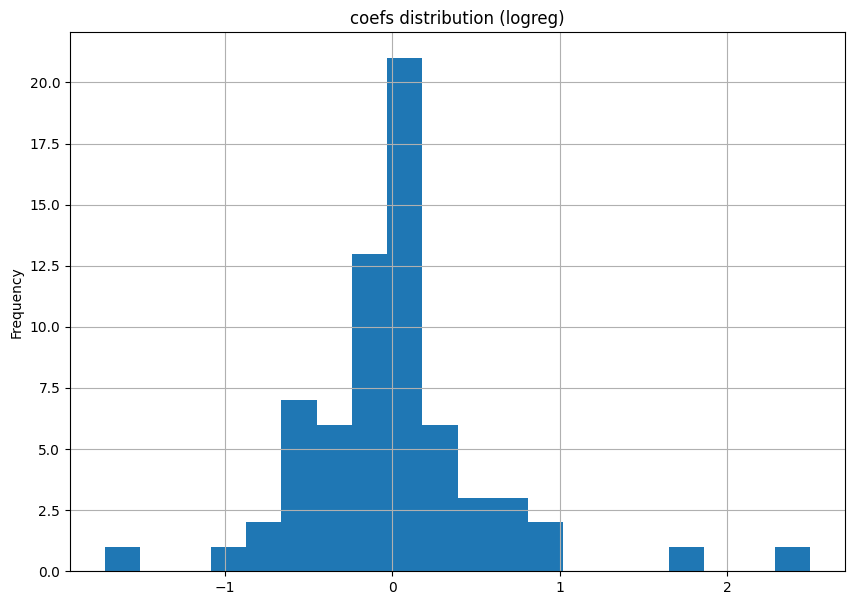

In [28]:
# посмотрим на распределение коэффициентов линейной модели
pd.Series(model.coef_[0])\
               .plot(kind='hist', bins=20, title='coefs distribution (logreg)',
                     xlabel='coef value', ylabel='number of coefs',
                     grid=True, figsize=(10, 7))
plt.show()

In [29]:
# отранжируем коэффициенты
coefs = pd.DataFrame(model.coef_[0], index=all_cols, columns=['coef'])
coefs = coefs.sort_values(by='coef', ascending=False)

coefs.head(6)

coef
previous_cancellations  2.495146
PRT                     1.861780
Transient               0.910927
FB                      0.829983
ITA                     0.685593
TA/TO                   0.663372

Целевой класс, т.е. ненадежный клиент у нас определен как "1", таким образом, положительные коэффициенты характеризуют именно склонность к данному классу. Общий "портрет" такоего клинета будет следущий:
* у клиента уже были отмены ранее;
* клиент из Португалии, Италии или Бразилии;
* в заказ включены завтрак, обед и ужин;
* клиент не связан с договором или групповым заездом.

### Шаг 6. Напишите общий вывод

In [30]:
print('рассчитаем прибыль на тестовой выборке с/без введения авансов по модельным предсказаниям')
print('прибыль без введения авансов - ', calc_profit(df_test))
print('прибыль c введения авансов по модельным предсказаниям - ', calc_profit(df_test, preds=preds))
print('прибыль c введения авансов по модельным предсказаниям со штрафом ("худший сценарий") - ', calc_profit(df_test, preds=preds, worst_scenario=True))

рассчитаем прибыль на тестовой выборке с/без введения авансов по модельным предсказаниям
прибыль без введения авансов -  35300770.0
прибыль c введения авансов по модельным предсказаниям -  44508474.0
прибыль c введения авансов по модельным предсказаниям со штрафом ("худший сценарий") -  31500640.0


Не сложно заметить, что бюджет, заложенный на разработку системы прогнозирования (400 т.р.), с лихвой покрывается за счет невозвратных авансов. Однако стоит также отметь, что условиями задачи не накладываются штрафы за неправильные прогнозы - иначе говоря, можно было бы достить более высоких значений прибыли с применение дамми-модели, предсказывающей только недобросовестное поведение клиента. Возможно, было бы интересно посмотреть на влияние негативных эффектов на прибыль, в случае, например, когда мы просим невозвратный аванс у "порядочного" клиента.